# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [394]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
import pandas_profiling as pp

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sympy import symbols, diff
from sklearn import preprocessing
from sklearn import metrics

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [358]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

In [299]:
print(np.array([2, 3]))
print(f(np.array([2, 3])))

[2 3]
0.846736667106623


Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [296]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return 2*np.sin(w)*np.cos(w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [298]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [359]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [360]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

/tmp/ipykernel_86/1727858522.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")
/tmp/ipykernel_86/1727858522.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


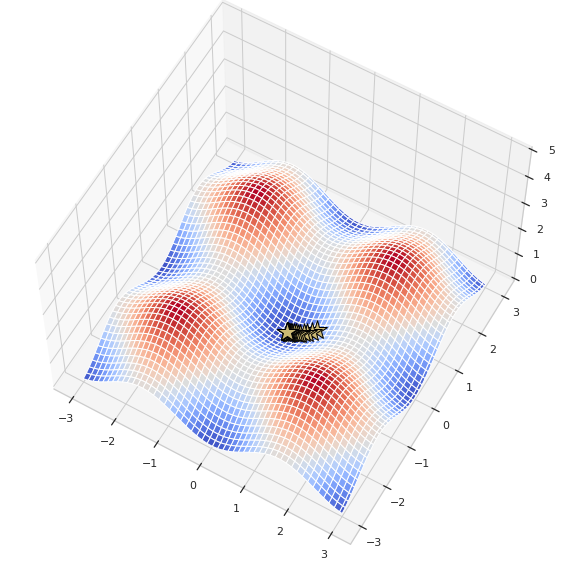

In [361]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

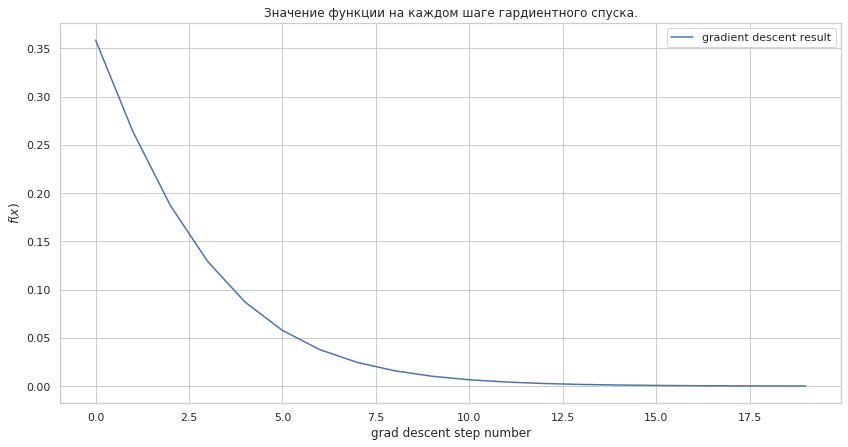

In [362]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [363]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.sum(np.square(y_true - y_pred)) / len(y_pred)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2 / len(y_pred) * X.T @ (y_pred - y_true)


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [364]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [365]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [373]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.matmul(X_test, self.W)
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [367]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

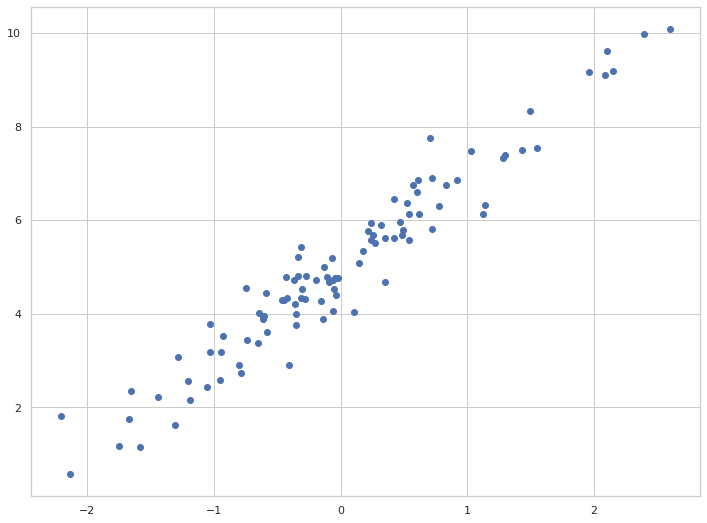

In [368]:
plt.scatter(X, y);

In [374]:
custom_lin_reg = CustomLinearRegression()

In [375]:
custom_lin_reg.fit(X, y)

My custom linear regression

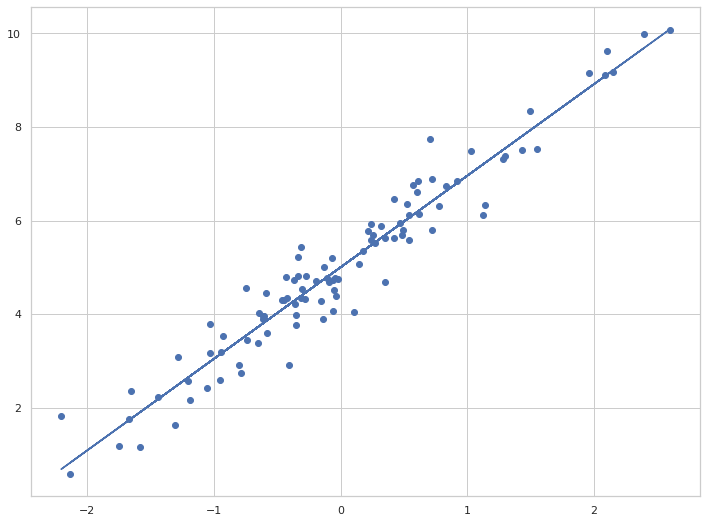

In [376]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [238]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

/home/mikhail/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

Ваш ход:

In [247]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('/mnt/c/IB2021-2022/ML/hw2/housing.csv', header=None, delimiter=r"\s+", names=column_names)
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [248]:
data.shape

(506, 14)

In [249]:
data.info

<bound method DataFrame.info of         CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24

In [250]:
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

In [315]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [251]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


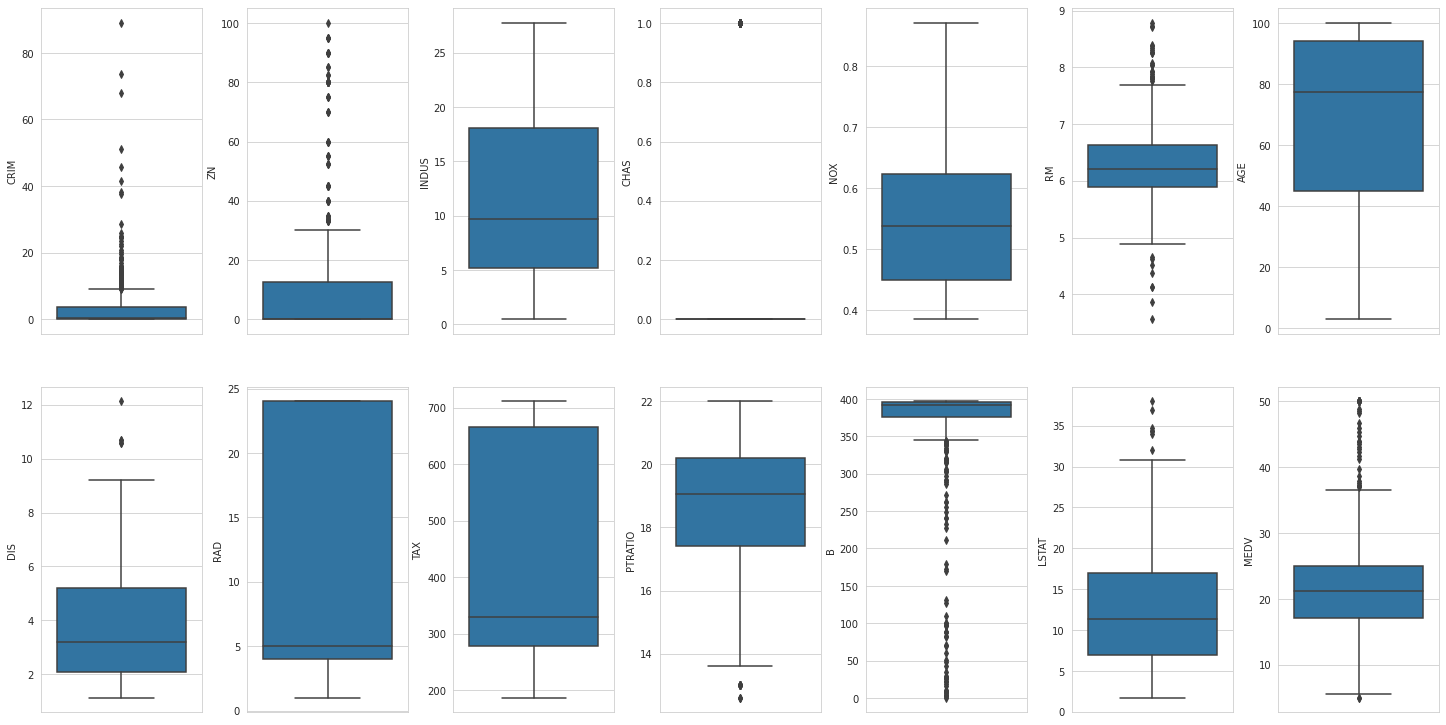

In [254]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [257]:
for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


In [377]:
data["CHAS"].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

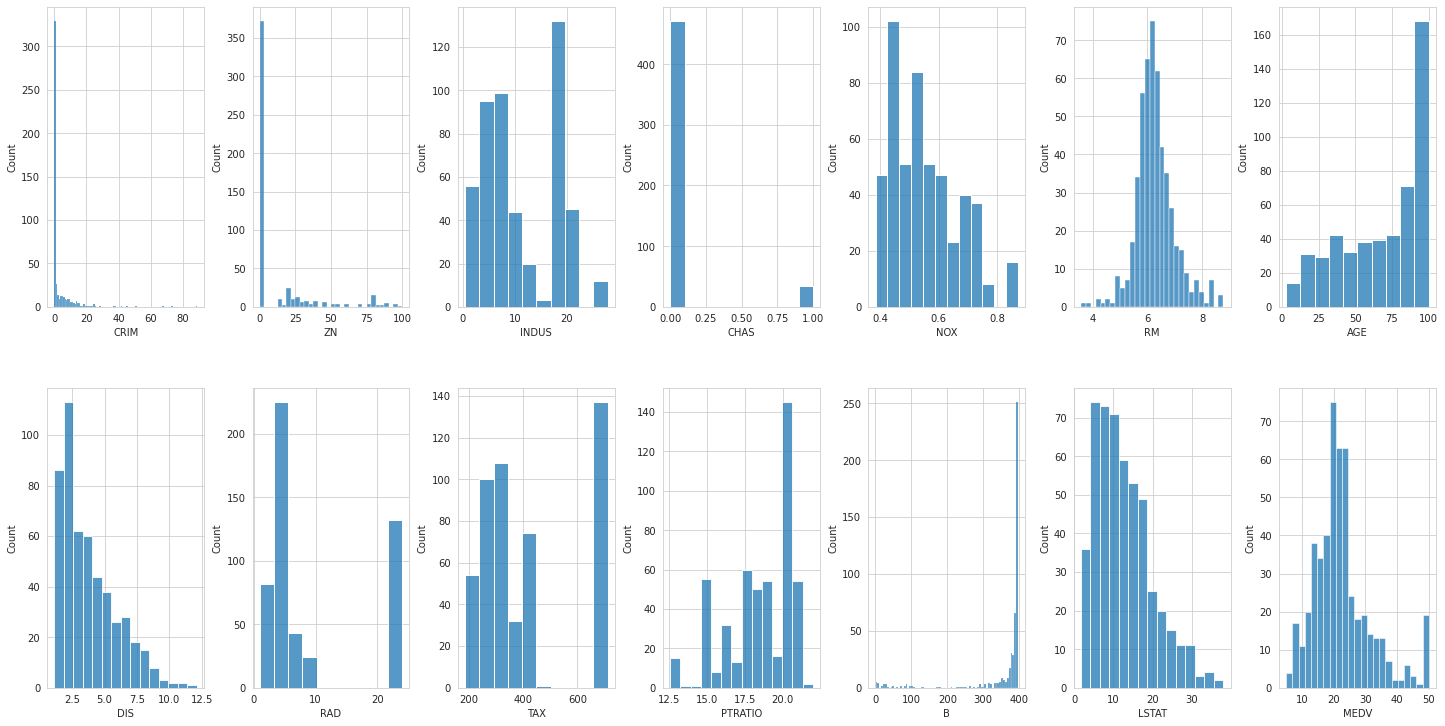

In [262]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

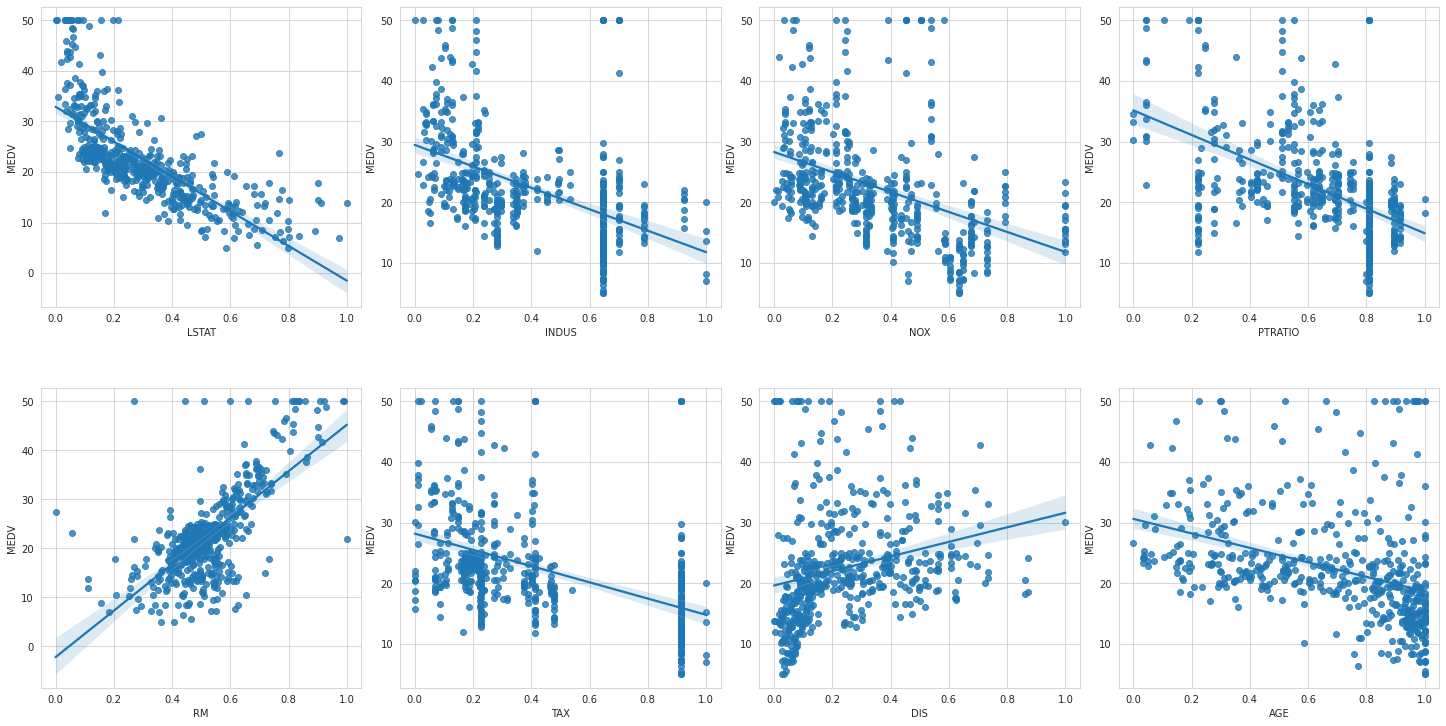

In [265]:
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Посчитаем корреляции различных показателей друг с другом

<AxesSubplot:>

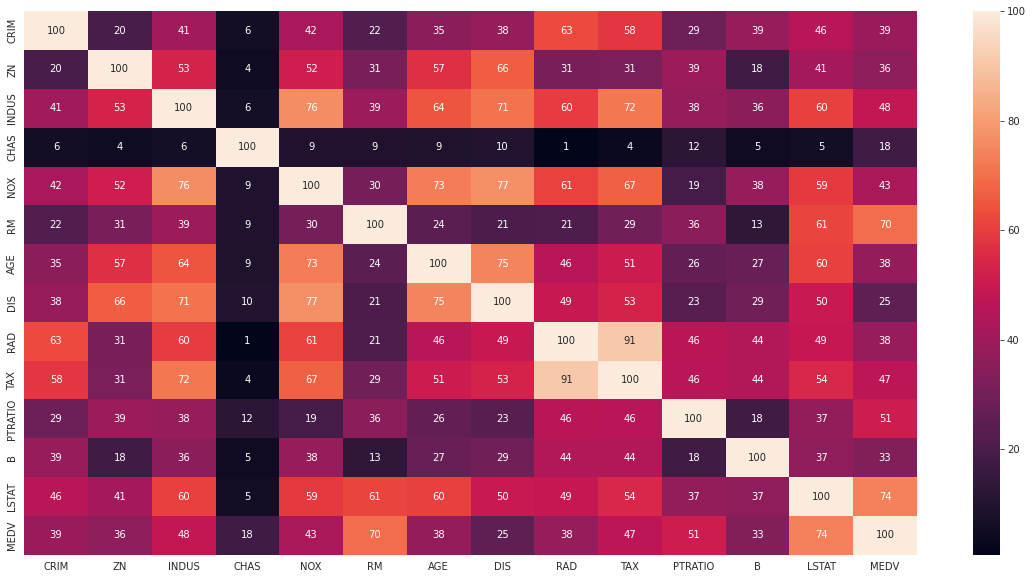

In [253]:
correlations = data.corr().abs()
plt.figure(figsize=(20, 10))
correlations = correlations * 100
sns.heatmap(correlations,annot = True,fmt = '.0f')

In [400]:
scaler_data = StandardScaler()
print(scaler_data.fit(data[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
                          'PTRATIO', 'B', 'LSTAT']]))

StandardScaler()


Стандартизуем данные и воспользуемся линейной регрессией

In [401]:
X_data = data.iloc[:, :-1]
y_data = data.iloc[:, -1]
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size=0.25, random_state=7)
X_data_train = scaler.fit_transform(X_data_train)
X_data_test = scaler.transform(X_data_test)
model_data = LinearRegression()
model_data.fit(X_data_train, y_data_train)
y_data_predicted = model_data.predict(X_data_test)
accuary_score_data = model_data.score(X_data_test, y_data_test)
print(f"Accuary score or coefficient of determination R2 is {accuary_score_data}")
print(f"Mean squared error is {mean_squared_error(y_data_test, y_data_predicted)}")
print("Coefficients: \n", model_data.coef_)

Accuary score or coefficient of determination R2 is 0.6170003090082052
Mean squared error is 29.515137790197585
Coefficients: 
 [-1.07978264  0.69494687  0.15453187  0.72986338 -1.74812722  3.78654532
 -0.29664157 -2.73094669  2.26495457 -1.81999273 -2.10165181  0.93220443
 -2.75876386]


Воспользуемся линейной регрессией не стандартизуя данные

In [402]:
X_data = data.iloc[:, :-1]
y_data = data.iloc[:, -1]
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size=0.25, random_state=7)
model_data = LinearRegression()
model_data.fit(X_data_train, y_data_train)
y_data_predicted = model_data.predict(X_data_test)
accuary_score_data = model_data.score(X_data_test, y_data_test)
print(f"Accuary score or coefficient of determination R2 is {accuary_score_data}")
print(f"Mean squared error is {mean_squared_error(y_data_test, y_data_predicted)}")
print("Coefficients: \n", model_data.coef_)

Accuary score or coefficient of determination R2 is 0.617000309008203
Mean squared error is 29.515137790197763
Coefficients: 
 [-1.29372986e-01  2.95904870e-02  2.22928425e-02  2.83744579e+00
 -1.53954203e+01  5.27557273e+00 -1.05383841e-02 -1.30170765e+00
  2.66392896e-01 -1.09686702e-02 -9.64830193e-01  1.08603361e-02
 -3.78363465e-01]


Разница между стандартизованными и изначальными данными видна только в коэффициентах

In [325]:
len(y_data_predicted)

127

Используя числовые данные мы смогли предсказать стоимость домов примерно в 62% случаев

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [385]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [386]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce = - 1 / n * np.sum(y_true * np.log(sigmoid(y_pred)) + (1 - y_true) * np.log(1 - sigmoid(y_pred)))
    return bce
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bce_grad = np.matmul(X.T, (y_pred - y_true))
    return bce_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [387]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(np.matmul(X_test, self.W))
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [388]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

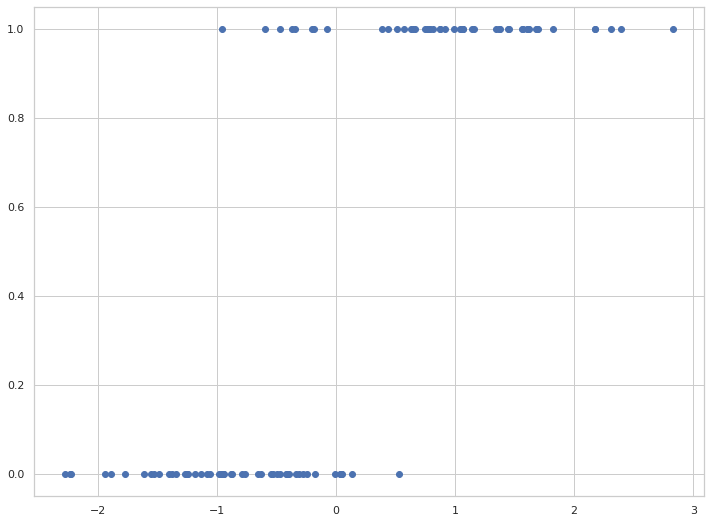

In [389]:
plt.scatter(X, y);

In [390]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

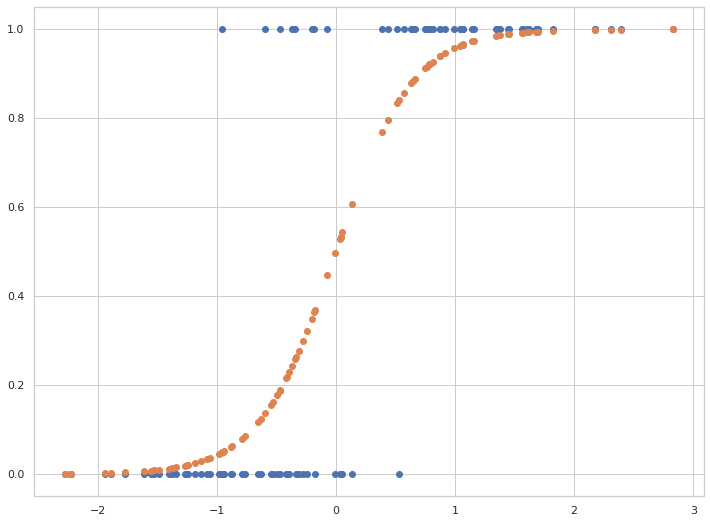

In [391]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [397]:
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f"Accuracy score is: {accuracy_score(y, y_pred)}")
print(f"Precision score is {precision_score(y, y_pred)}")
print(f"Recall score is {recall_score(y, y_pred)}")
print(f"F1 score is: {round(f1_score(y, y_pred), 2)}")

Accuracy score is: 0.86
Precision score is 0.875
Recall score is 0.84
F1 score is: 0.86


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

Прочитаем файл

In [107]:
pokemon = pd.read_csv("/mnt/c/IB2021-2022/ML/hw2/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Переименуем колонки, сделав их более единообразными и лёгкими для работы

In [108]:
pokemon_columns = pokemon.columns
pokemon_columns_renamed = [i.lower().replace(' ', '_').replace('.', '') for i in pokemon_columns]
pokemon = pokemon.rename(columns = dict(zip(pokemon_columns, pokemon_columns_renamed)))
pokemon[:3]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


Посмотрим на основные статистики и проведём краткий анализ данных

In [353]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   #                  800 non-null    int64 
 1   name               800 non-null    object
 2   type_1             800 non-null    object
 3   type_2             414 non-null    object
 4   total              800 non-null    int64 
 5   hp                 800 non-null    int64 
 6   attack             800 non-null    int64 
 7   defense            800 non-null    int64 
 8   sp_atk             800 non-null    int64 
 9   sp_def             800 non-null    int64 
 10  speed              800 non-null    int64 
 11  generation         800 non-null    int64 
 12  legendary          800 non-null    bool  
 13  has_one_type       800 non-null    bool  
 14  is_type1_Psychic   800 non-null    bool  
 15  is_type1_Dragon    800 non-null    bool  
 16  is_type1_Fire      800 non-null    bool  
 1

In [110]:
pokemon.dtypes

#              int64
name          object
type_1        object
type_2        object
total          int64
hp             int64
attack         int64
defense        int64
sp_atk         int64
sp_def         int64
speed          int64
generation     int64
legendary       bool
dtype: object

In [111]:
pokemon.describe()

,#,total,hp,attack,defense,sp_atk,sp_def,speed,generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Проверим наличие пропущенных или отсутсвующих элементов

In [60]:
pokemon.isnull().sum()

#               0
name            0
type_1          0
type_2        386
total           0
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
generation      0
legendary       0
dtype: int64

Создадим новый датафрейм с числовыми данными

In [267]:
pokemon_numbers = pokemon.iloc[:, 4:12]
pokemon_numbers[:3]

,total,hp,attack,defense,sp_atk,sp_def,speed,generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1


Посмотрим на распределения этих данных

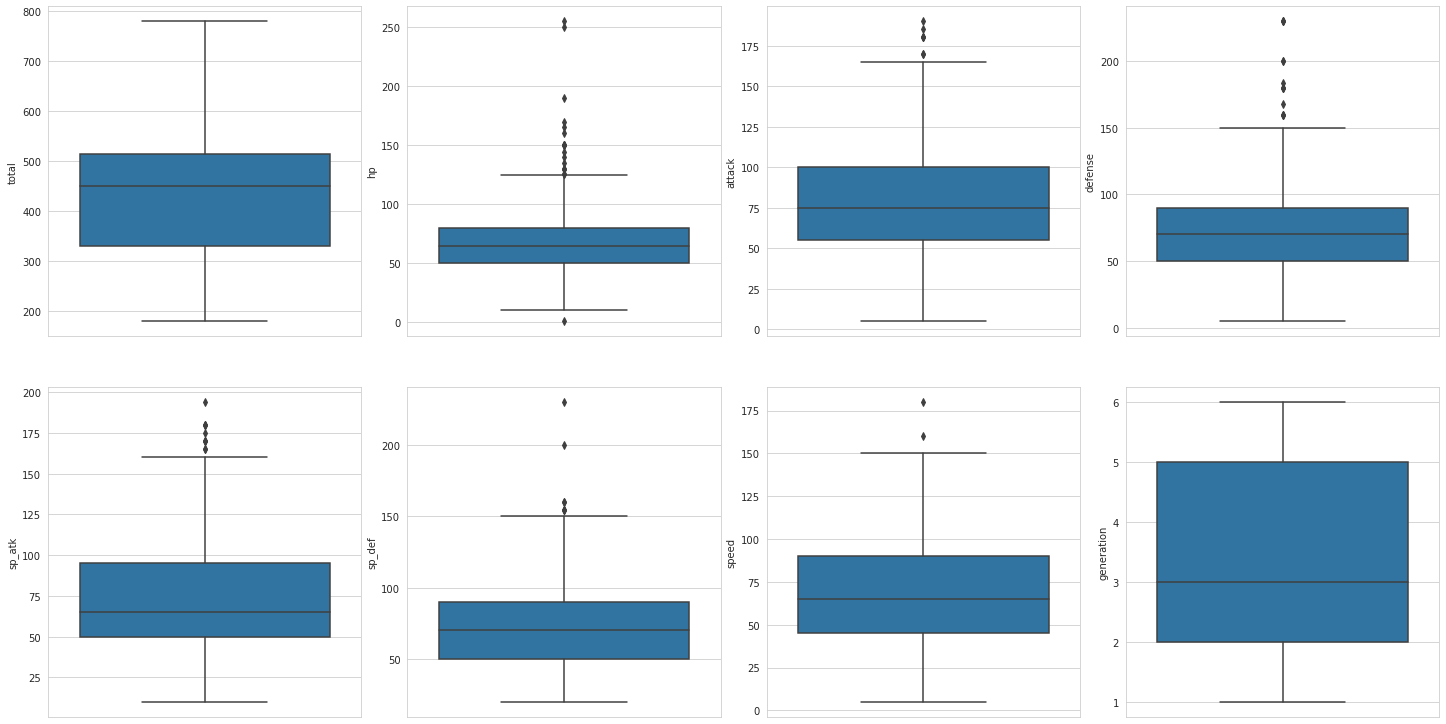

In [269]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in pokemon_numbers.items():
    sns.boxplot(y=k, data=pokemon_numbers, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

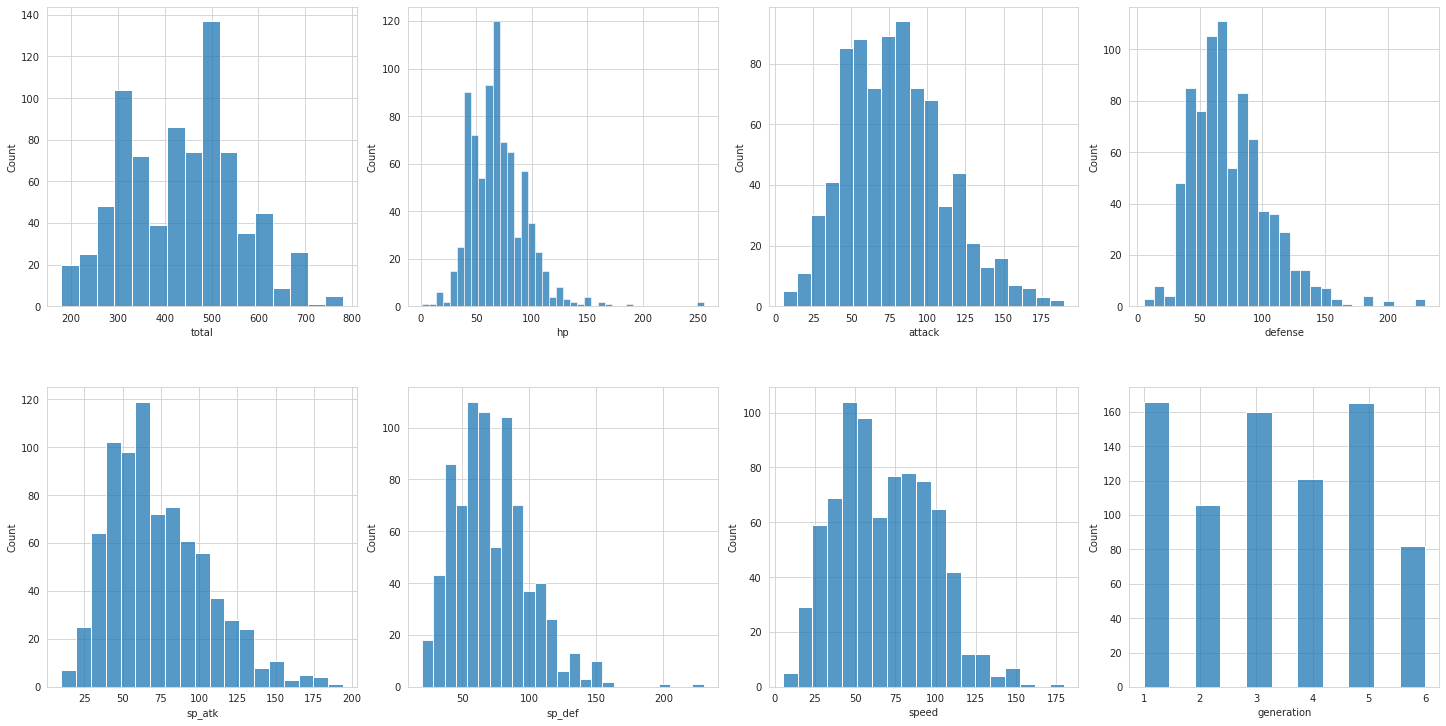

In [270]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in pokemon_numbers.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [304]:
pokemon_numbers_legendary = pokemon.iloc[:, 4:13]
pokemon_numbers_legendary[:3]

,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
0,318,45,49,49,65,65,45,1,False
1,405,60,62,63,80,80,60,1,False
2,525,80,82,83,100,100,80,1,False


In [312]:
pokemon_numbers_legendary['legendary_category'] = np.where(pokemon['legendary'] == True, 'legendary', 'non-legendary')
pokemon_numbers_legendary[:3]

,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary,legendary_category
0,318,45,49,49,65,65,45,1,False,non-legendary
1,405,60,62,63,80,80,60,1,False,non-legendary
2,525,80,82,83,100,100,80,1,False,non-legendary


In [313]:
pokemon_numbers_legendary['legendary_category'].unique()

array(['non-legendary', 'legendary'], dtype=object)

In [309]:
pokemon_numbers_legendary.columns

Index(['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed',
       'generation', 'legendary'],
      dtype='object')

In [310]:
pokemon_numbers_legendary.legendary.unique()

array([False,  True])

In [275]:
for k, v in pokemon_numbers.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column total outliers = 0.00%
Column hp outliers = 4.55%
Column attack outliers = 1.38%
Column defense outliers = 3.95%
Column sp_atk outliers = 1.98%
Column sp_def outliers = 2.77%
Column speed outliers = 0.40%
Column generation outliers = 0.00%


In [272]:
pokemon.columns

Index(['#', 'name', 'type_1', 'type_2', 'total', 'hp', 'attack', 'defense',
       'sp_atk', 'sp_def', 'speed', 'generation', 'legendary', 'has_one_type',
       'is_type1_Psychic', 'is_type1_Dragon', 'is_type1_Fire',
       'is_type2_Flying', 'is_type2_Psychic', 'is_type2_Dragon',
       'is_type2_Fighting'],
      dtype='object')

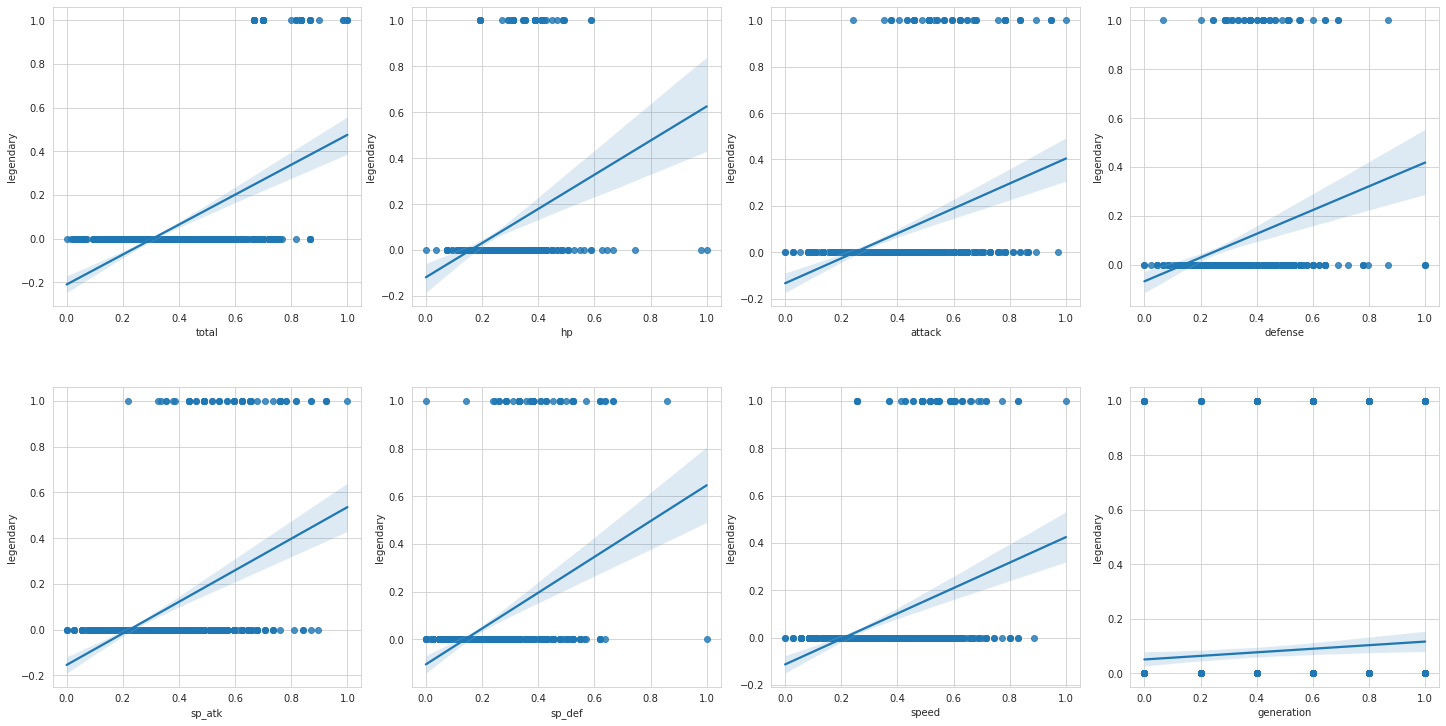

In [273]:
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed',
               'generation']
x = pokemon.loc[:,column_sels]
y = pokemon['legendary']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [274]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [ ]:
scaler2 = StandardScaler()
print(scaler2.fit(pokemon[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]))

Посмотрим на корреляцию основных численных характеристик покемонов друг с другом.
Обратим особое внимание на корреляцию с легендарностью

<AxesSubplot:>

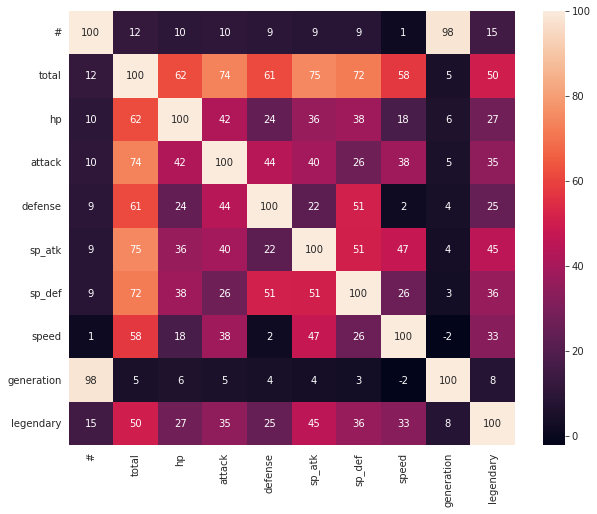

In [112]:
correlations = pokemon.corr()
plt.figure(figsize=(10,8))
correlations = correlations * 100
sns.heatmap(correlations,annot = True,fmt = '.0f')

Посмотрим, какие бывают типы покемонов

In [114]:
pokemon['type_1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [115]:
pokemon['type_2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

In [113]:
pokemon_type1 = pokemon \
        .groupby('type_1', as_index=False) \
        .aggregate({'total': 'count'}) \
        .sort_values('total', ascending=False)
pokemon_type1

,type_1,total
17,Water,112
12,Normal,98
9,Grass,70
0,Bug,69
14,Psychic,57
6,Fire,52
3,Electric,44
15,Rock,44
8,Ghost,32
10,Ground,32


In [79]:
pokemon_type1.describe()

,total
count,18.000000
mean,44.444444
std,27.901554
min,4.000000
25%,27.250000
50%,32.000000
75%,55.750000
max,112.000000


In [80]:
pokemon_type2 = pokemon \
        .groupby('type_2', as_index=False) \
        .aggregate({'total': 'count'}) \
        .sort_values('total', ascending=False)
pokemon_type2

,type_2,total
7,Flying,97
10,Ground,35
13,Poison,34
14,Psychic,33
5,Fighting,26
9,Grass,25
4,Fairy,23
16,Steel,22
1,Dark,20
2,Dragon,18


In [81]:
pokemon_type2.describe()

,total
count,18.000000
mean,23.000000
std,20.841136
min,3.000000
25%,14.000000
50%,19.000000
75%,25.750000
max,97.000000


Посчитаем количество легендарных покемонов

In [64]:
pokemon.query("legendary == True") \
       .count()

#             65
name          65
type_1        65
type_2        40
total         65
hp            65
attack        65
defense       65
sp_atk        65
sp_def        65
speed         65
generation    65
legendary     65
dtype: int64

Посмотрим, каких типов среди легендарных покемонов больше

In [65]:
pokemon_legendary_type_1 = pokemon.query("legendary == True") \
        .groupby(['type_1'], as_index=False) \
        .aggregate({'legendary': 'count'}) \
        .sort_values('legendary', ascending=False)
pokemon_legendary_type_1

,type_1,legendary
11,Psychic,14
1,Dragon,12
4,Fire,5
2,Electric,4
8,Ground,4
12,Rock,4
13,Steel,4
14,Water,4
7,Grass,3
0,Dark,2


In [66]:
pokemon_legendary_type_1.describe()

,legendary
count,15.000000
mean,4.333333
std,3.716117
min,1.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,14.000000


In [67]:
pokemon_legendary_type_2 = pokemon.query("legendary == True") \
        .groupby('type_2', as_index=False) \
        .aggregate({'legendary': 'count'}) \
        .sort_values('legendary', ascending=False)
pokemon_legendary_type_2

,type_2,legendary
6,Flying,13
10,Psychic,5
1,Dragon,4
4,Fighting,4
5,Fire,3
9,Ice,3
3,Fairy,2
0,Dark,1
2,Electric,1
7,Ghost,1


In [68]:
pokemon_legendary_type_2.describe()

,legendary
count,13.000000
mean,3.076923
std,3.303068
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,13.000000


/tmp/ipykernel_86/2653140894.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


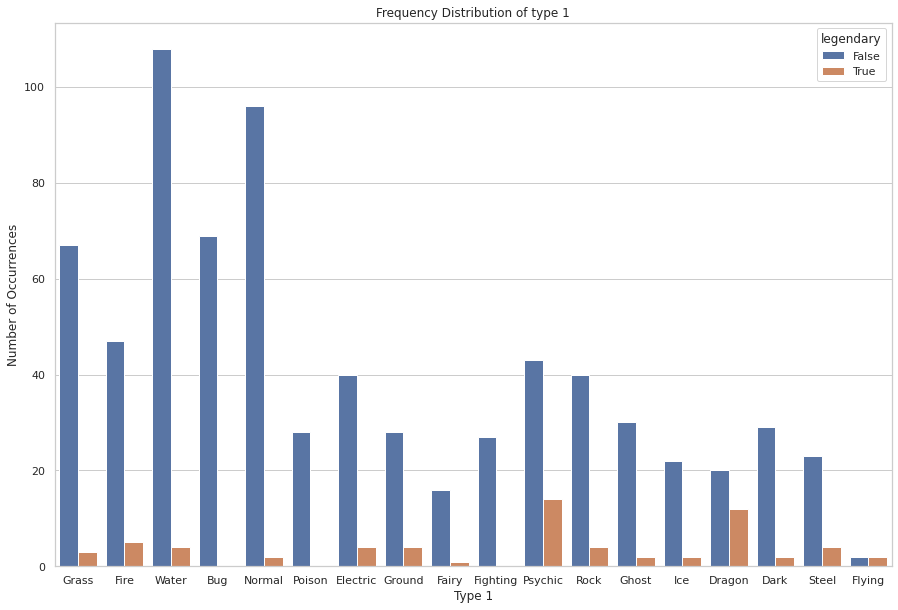

In [354]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x="type_1", data=pokemon,
           hue="legendary")
plt.title('Распределение покемонов по типу 1')
plt.ylabel('Количество покемонов', fontsize=12)
plt.xlabel('Type 1', fontsize=12)
plt.show()

/tmp/ipykernel_86/2718512664.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


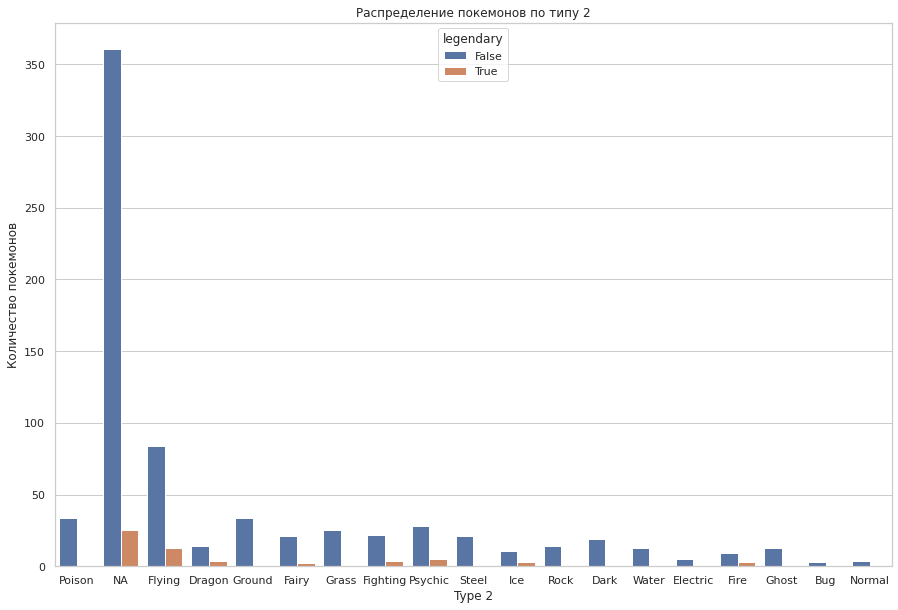

In [357]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x="type_2", data=pokemon.fillna("NA"),
           hue="legendary")
plt.title('Распределение покемонов по типу 2')
plt.ylabel('Количество покемонов', fontsize=12)
plt.xlabel('Type 2', fontsize=12)
plt.show()

Мы видим, что некоторых типов среди легендарных больше чем остальных. Это можно будет использовать для улучшения нашей модели.

Вспомним, что единственные пропущенные значения в таблице встречлись для типа 2, что говорит о том, что эти покемоны имеют только один тип. Покемонов с одним типом около половины (386 из 800)

In [117]:
pokemon[pokemon.isna().any(axis=1)]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False
11,9,Blastoise,Water,NaN,530,79,83,100,85,105,78,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,705,Sliggoo,Dragon,NaN,452,68,75,53,83,113,60,6,False
776,706,Goodra,Dragon,NaN,600,90,100,70,110,150,80,6,False
788,712,Bergmite,Ice,NaN,304,55,69,85,32,35,28,6,False
789,713,Avalugg,Ice,NaN,514,95,117,184,44,46,28,6,False


Добавим новый столбец, соответствующий наличию одного или двух типов

In [132]:
pokemon['has_one_type'] = pokemon['type_2'].isna()
pokemon[:3]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary,has_one_type
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,False


Проверим, что столбец успешно создался и соответствует ожиданиям

In [133]:
pokemon['has_one_type'].unique()

array([False,  True])

In [135]:
pokemon.groupby('has_one_type', as_index=False) \
       .aggregate({'has_one_type': 'count'})

,has_one_type
0,414
1,386


In [138]:
pokemon.groupby(['has_one_type', 'legendary'], as_index=False) \
       .aggregate({'has_one_type': 'count'})

,legendary,has_one_type
0,False,374
1,True,40
2,False,361
3,True,25


Добавим новые столбцы, соответствующие типам покемонов, которых больше чем в среднем среди легендарных

In [136]:
pokemon['is_type1_Psychic'] = np.where(pokemon['type_1'] == 'Psychic', True, False)
pokemon['is_type1_Dragon'] = np.where(pokemon['type_1'] == 'Dragon', True, False)
pokemon['is_type1_Fire'] = np.where(pokemon['type_1'] == 'Fire', True, False)
pokemon['is_type2_Flying'] = np.where(pokemon['type_2'] == 'Flying', True, False)
pokemon['is_type2_Psychic'] = np.where(pokemon['type_2'] == 'Psychic', True, False)
pokemon['is_type2_Dragon'] = np.where(pokemon['type_2'] == 'Dragon', True, False)
pokemon['is_type2_Fighting'] = np.where(pokemon['type_2'] == 'Fighting', True, False)
pokemon[:3]

,#,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,...,generation,legendary,has_one_type,is_type1_Psychic,is_type1_Dragon,is_type1_Fire,is_type2_Flying,is_type2_Psychic,is_type2_Dragon,is_type2_Fighting
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,1,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,1,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,1,False,False,False,False,False,False,False,False,False


Посмотрим, насколько высока корреляция новых признаков с легендарностью

<AxesSubplot:>

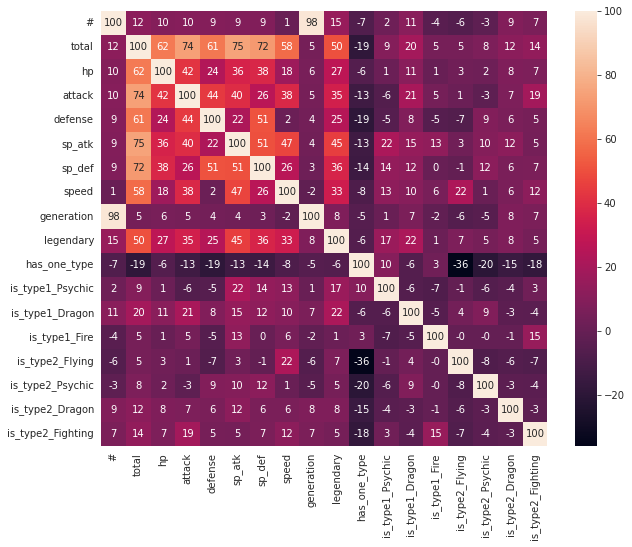

In [137]:
correlations = pokemon.corr()
plt.figure(figsize=(10,8))
correlations = correlations * 100
sns.heatmap(correlations,annot = True,fmt = '.0f')

Видим, что корреляция в целом невысока, самая большая для покемонов с психическим или драконьим первым типом. Однако, она всё ещё меньше чем с любой другой количественной характеристикой

In [236]:
scaler = StandardScaler()
print(scaler.fit(pokemon[['hp','attack','defense','sp_atk','sp_def','speed']]))

StandardScaler()


In [149]:
cat = pokemon.astype({'name': 'category', 'type_1': 'category', 'type_2': 'category'})

In [152]:
pokemon.dtypes

#                     int64
name                 object
type_1               object
type_2               object
total                 int64
hp                    int64
attack                int64
defense               int64
sp_atk                int64
sp_def                int64
speed                 int64
generation            int64
legendary              bool
has_one_type           bool
is_type1_Psychic       bool
is_type1_Dragon        bool
is_type1_Fire          bool
is_type2_Flying        bool
is_type2_Psychic       bool
is_type2_Dragon        bool
is_type2_Fighting      bool
dtype: object

In [155]:
pokemon.iloc[:, 12]

0      False
1      False
2      False
3      False
4      False
       ...  
795     True
796     True
797     True
798     True
799     True
Name: legendary, Length: 800, dtype: bool

In [326]:
X = pokemon.iloc[:, 4:12]
y = pokemon.iloc[:, 12]

In [327]:
X

,total,hp,attack,defense,sp_atk,sp_def,speed,generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1
...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6
796,700,50,160,110,160,110,110,6
797,600,80,110,60,150,130,70,6
798,680,80,160,60,170,130,80,6


Разобьём на тренировочную и тестовую выборки 
Fitting the train data in the model

In [403]:
X_pokemon = pokemon.iloc[:, 4:12]
y_pokemon = pokemon.iloc[:, 12]

In [404]:
scaler = StandardScaler()
scaler.fit(X_pokemon)

StandardScaler()

In [405]:
X_pokemon_train, X_pokemon_test, y_pokemon_train, y_pokemon_test = \
                                train_test_split(X_pokemon, y_pokemon, test_size=0.25, random_state=7)
X_pokemon_train = scaler.fit_transform(X_pokemon_train)
X_pokemon_test = scaler.transform(X_pokemon_test)
model_pokemon = LogisticRegression()
model_pokemon.fit(X_pokemon_train, y_pokemon_train)
accuary_score_pokemon = model_pokemon.score(X_pokemon_test, y_pokemon_test)
accuary_score_pokemon

0.925

Получилось 0.925

In [233]:
scaler1 = StandardScaler()
print(scaler1.fit(pokemon[X1.columns]))

StandardScaler()


In [232]:
X1.columns

Index(['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed',
       'generation', 'has_one_type', 'is_type1_Psychic', 'is_type1_Dragon',
       'is_type1_Fire', 'is_type2_Flying', 'is_type2_Psychic',
       'is_type2_Dragon', 'is_type2_Fighting'],
      dtype='object')

Добавим в модель данные по типам покемонов, которые чаще встречаются среди легендарных

In [411]:
X1 = pokemon.iloc[:, 4:]
del X1['legendary']
y1 = pokemon.iloc[:, 12]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=7)
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)
model1 = LogisticRegression()
model1.fit(X1_train, y1_train)
accuary_score = model1.score(X1_test, y1_test)
accuary_score

0.945

Получилось 0.945

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

Разделите ваши данные на тестовую и тренировочную выборку.

In [407]:
X_pokemon = pokemon.iloc[:, 4:12]
y_pokemon = pokemon.iloc[:, 12]
X_pokemon_train, X_pokemon_test, y_pokemon_train, y_pokemon_test = \
                                train_test_split(X_pokemon, y_pokemon, test_size=0.25, random_state=7)

Обучите модель `LogisticRegression` из `sklearn`.

In [408]:
scaler = StandardScaler()
scaler.fit(X_pokemon)
model_pokemon = LogisticRegression()
model_pokemon.fit(X_pokemon_train, y_pokemon_train)
accuary_score_pokemon = model_pokemon.score(X_pokemon_test, y_pokemon_test)
accuary_score_pokemon

0.935

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

[[176   5]
 [  8  11]]


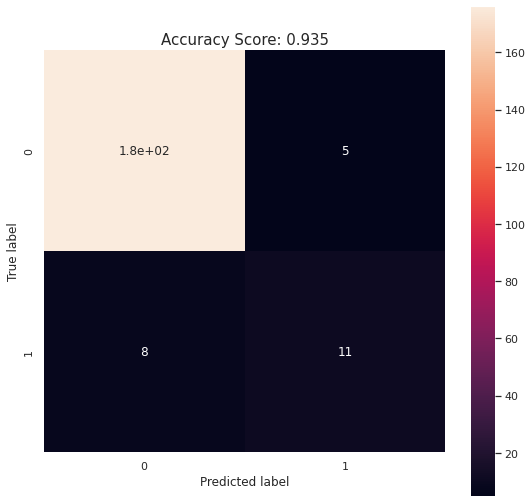

In [398]:
y_pokemon_predicted = model_pokemon.predict(X_pokemon_test)
confusion = metrics.confusion_matrix(y_pokemon_test, y_pokemon_predicted)
print(confusion)
plt.figure(figsize=(9,9))
sns.heatmap(confusion, annot=True, square = True);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {accuary_score_pokemon}'
plt.title(all_sample_title, size = 15);

[[177   4]
 [  7  12]]


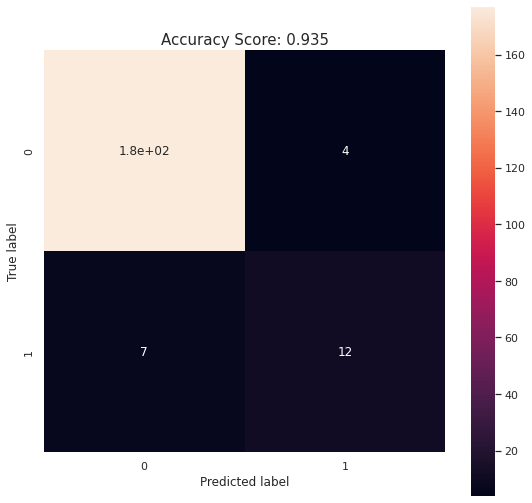

In [414]:
y1_predicted = model1.predict(X1_test)
confusion = metrics.confusion_matrix(y1_test, y1_predicted)
print(confusion)
plt.figure(figsize=(9,9))
sns.heatmap(confusion, annot=True, square = True);
plt.ylabel('True label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {accuary_score_pokemon}'
plt.title(all_sample_title, size = 15);

/tmp/ipykernel_86/562309408.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


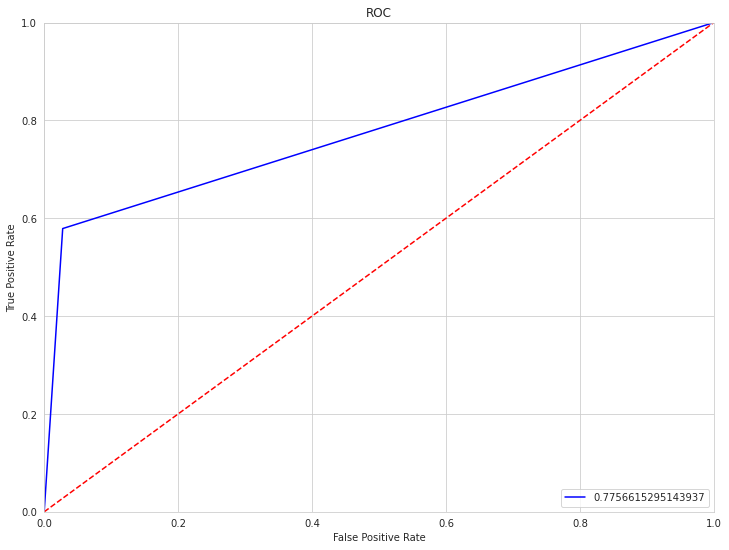

In [350]:
fpr, tpr, threshold = metrics.roc_curve(y_pokemon_test, y_pokemon_predicted)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [352]:
r_sq = model_pokemon.score(X_pokemon_test, y_pokemon_test)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model_pokemon.intercept_)

# Print the Slope:
print('slope:', model_pokemon.coef_)

coefficient of determination: 0.935
intercept: [-23.38659185]
slope: [[ 0.03032362  0.00777526 -0.00529522 -0.02156549  0.00321849  0.02819479
   0.0179958   0.45008674]]


In [ ]:
pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logistic.coef_))], axis = 1)

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Последнее время мне нравится группа "Немного нервно".\
Наиболее любимые треки:\
Жанна - про Жанну д'Арк,\
Винсент - про Ван Гога,\
Дело идет к декабрю - про всё хорошее

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Задания с анализом данных настолько же интересные, насколько сложно даются задания на понимание математики, лежащей в основе методов и написание своих функций.
Много душевных сил уходит на то, чтобы не сбежать в ужасе при виде заданий (хотя очень хочется), а вместо этого брать себя в руки, садиться и разбираться, чтобы начать что-то понимать.